# Self-Driving Car Engineer Nanodegree

## Project: **Finding Lane Lines on the Road** 

In [1]:
#importing some useful packages
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import cv2
import math
from moviepy.editor import VideoFileClip

%matplotlib inline

import datetime
import pprint
pp = pprint.PrettyPrinter(indent=4)


In [2]:
%%HTML
<style> code {background-color : orange !important;} </style>
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

## Helper Functions

I am not currently using these helpers but I have left them here for future development

In [3]:
import math

def grayscale(img):
    """Applies the Grayscale transform
    This will return an image with only one color channel
    but NOTE: to see the returned image as grayscale
    (assuming your grayscaled image is called 'gray')
    you should call plt.imshow(gray, cmap='gray')"""
    return cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # Or use BGR2GRAY if you read an image with cv2.imread()
    # return cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    
def canny(img, low_threshold, high_threshold):
    """Applies the Canny transform"""
    return cv2.Canny(img, low_threshold, high_threshold)

def gaussian_blur(img, kernel_size):
    """Applies a Gaussian Noise kernel"""
    return cv2.GaussianBlur(img, (kernel_size, kernel_size), 0)

def region_of_interest(img, vertices):
    """
    Applies an image mask.
    
    Only keeps the region of the image defined by the polygon
    formed from `vertices`. The rest of the image is set to black.
    `vertices` should be a numpy array of integer points.
    """
    #defining a blank mask to start with
    mask = np.zeros_like(img)   
    
    #defining a 3 channel or 1 channel color to fill the mask with depending on the input image
    if len(img.shape) > 2:
        channel_count = img.shape[2]  # i.e. 3 or 4 depending on your image
        ignore_mask_color = (255,) * channel_count
    else:
        ignore_mask_color = 255
        
    #filling pixels inside the polygon defined by "vertices" with the fill color    
    cv2.fillPoly(mask, vertices, ignore_mask_color)
    
    #returning the image only where mask pixels are nonzero
    masked_image = cv2.bitwise_and(img, mask)
    return masked_image


def draw_lines(img, lines, color=[255, 0, 0], thickness=2):
    """
    NOTE: this is the function you might want to use as a starting point once you want to 
    average/extrapolate the line segments you detect to map out the full
    extent of the lane (going from the result shown in raw-lines-example.mp4
    to that shown in P1_example.mp4).  
    
    Think about things like separating line segments by their 
    slope ((y2-y1)/(x2-x1)) to decide which segments are part of the left
    line vs. the right line.  Then, you can average the position of each of 
    the lines and extrapolate to the top and bottom of the lane.
    
    This function draws `lines` with `color` and `thickness`.    
    Lines are drawn on the image inplace (mutates the image).
    If you want to make the lines semi-transparent, think about combining
    this function with the weighted_img() function below
    """
    for line in lines:
        for x1,y1,x2,y2 in line:
            cv2.line(img, (x1, y1), (x2, y2), color, thickness)

def hough_lines(img, rho, theta, threshold, min_line_len, max_line_gap):
    """
    `img` should be the output of a Canny transform.
        
    Returns an image with hough lines drawn.
    """
    lines = cv2.HoughLinesP(img, rho, theta, threshold, np.array([]), minLineLength=min_line_len, maxLineGap=max_line_gap)
    line_img = np.zeros((img.shape[0], img.shape[1], 3), dtype=np.uint8)
    draw_lines(line_img, lines)
    return line_img

# Python 3 has support for cool math symbols.

def weighted_img(img, initial_img, α=0.8, β=1., γ=0.):
    """
    `img` is the output of the hough_lines(), An image with lines drawn on it.
    Should be a blank image (all black) with lines drawn on it.
    
    `initial_img` should be the image before any processing.
    
    The result image is computed as follows:
    
    initial_img * α + img * β + γ
    NOTE: initial_img and img must be the same shape!
    """
    return cv2.addWeighted(initial_img, α, img, β, γ)

In [4]:
def CalcSlope(lineSegIn):
    x1,y1,x2,y2 = lineSegIn
    slopeOut = (y2-y1)/(x2-x1)
    return(slopeOut)

def ExtendLineSegment(lineSegIn, extFactor = 0.25):
    x1,y1,x2,y2 = lineSegIn
    dx = x2 - x1
    dy = y2 - y1
    
    # This here is deeply cheesy!
    # Only extend the segment toward the bottom of the image
    if (dy > 0):
        x3 = int(round(x2 + extFactor * dx))
        y3 = int(round(y2 + extFactor * dy))
        x0 = x1
        y0 = y1
    else:
        x3 = x2
        y3 = y2
        x0 = int(round(x1 - extFactor * dx))
        y0 = int(round(y1 - extFactor * dy))
        
    lineSegOut = (x0,y0,x3,y3)
    return(lineSegOut)
                       

In [5]:
def PlotImageRecords(imgRecords):
    fig = plt.gcf()
    fig.set_size_inches(12,4)
    fig.set_dpi(180)

    numImages = len(imgRecords)
    numCols = 4
    numRows = math.ceil(numImages/numCols) 
    for recIndex, imgRecord in enumerate(imgRecords):
        name, img = imgRecord

        plt.subplot(numRows, numCols, recIndex+1)
        plt.title(name)
        plt.axis('off')
        plt.imshow(img)
        
    #plt.tight_layout()
    #plt.show()        

#PlotImageRecords(pipelineImgRecords)
    

## Test Images


In [6]:
import os
from glob import glob
g_outputDir = "test_videos_output"

glob_pattern = os.path.join("test_images/", "*.jpg")
tmpFileNames = glob(glob_pattern)
g_testImgFileNames = tmpFileNames
g_testImgFileNamesFQ = [os.path.abspath(fileName) for fileName in tmpFileNames]


## Main Pipeline Implementation

In [7]:
def ProcessImage(imgIn):
    """
    Wrapper function - because moviepy process function does not like the extra return obj
    """
    pipelineImages, imgOut = ProcessImageLowlevel(imgIn)
    return imgOut
    
def ProcessImageLowlevel(imgIn, imgInFileName="imageIn"):
    """
    Create the pipeline processed image on the input image.
    :param imgIn: Input matplotlib image
    :param imgInFileName: Optional filename of the input image - for debug display
    :returns imgOut: The processed image final result
    :returns pipelineImages: A list of the intermediate images of the pipeline for debug display
    """
    imgGray = cv2.cvtColor(imgIn, cv2.COLOR_RGB2GRAY)

    # Define a kernel size and apply Gaussian smoothing
    kernelSize = (5, 5)
    imgBlurGray = cv2.GaussianBlur(imgGray, kernelSize, 0)

    # Define our parameters for Canny and apply
    low_threshold = 50
    high_threshold = 150
    imgEdges = cv2.Canny(imgBlurGray, low_threshold, high_threshold)

    # This time we are defining a four sided polygon to mask
    # Next we'll create a masked edges image using cv2.fillPoly()
    maskROI = np.zeros_like(imgEdges)   
    ignore_mask_color = 255   
    
    # Region of interest mask polygon
    iHeight = imgIn.shape[0]
    iWidth = imgIn.shape[1]
    trapTop = 320
    leftbottom = (110, iHeight)
    lefttop = (440, trapTop)
    righttop = (520, trapTop)
    rightbottom = (iWidth-75, iHeight)
    
    vertices = np.array([[ leftbottom, lefttop, righttop, rightbottom]], dtype=np.int32)
    cv2.fillPoly(maskROI, vertices, ignore_mask_color)
    imgMaskedEdges = cv2.bitwise_and(imgEdges, maskROI)
    
    maskROI3Ch = np.dstack((maskROI, maskROI, maskROI)) 
    imgMaskedInput = cv2.bitwise_and(imgIn, maskROI3Ch)
    
    # Define the Hough transform parameters
    # Make a blank the same size as our image to draw on
    rho = 1 # distance resolution in pixels of the Hough grid
    theta =   0.1 * np.pi/180 # angular resolution in radians of the Hough grid
    threshold = 50    # minimum number of votes (intersections in Hough grid cell)
    min_line_length = 50#minimum number of pixels making up a line
    max_line_gap = 200    # maximum gap in pixels between connectable line segments
    imgLines = np.zeros_like(imgIn)   
    
    # Run Hough on edge detected image
    # Output "lines" is an array containing endpoints of detected line segments
    lines = cv2.HoughLinesP(imgMaskedEdges, rho, theta, threshold, np.array([]), min_line_length, max_line_gap)

    # Iterate over the output "lines" and draw lines on a blank image
    print("numLines: ", len(lines))
    slopesP = []
    slopesN = []
    
    for line in lines:  
        #print(line[0])
        for x1,y1,x2,y2 in line:            
            cv2.line(imgLines, (x1,y1), (x2,y2), (255,0,0), 10)
            lineExt = ExtendLineSegment(line[0], extFactor = 1)
            x1,y1,x2,y2 = lineExt
            cv2.line(imgLines, (x1,y1), (x2,y2), (255,0,0), 10)
            
            slope = CalcSlope(line[0])          
            if (slope > 0):
                slopesP.append(slope)
            else:
                slopesN.append(slope)            
            
    # Create a "color" binary image to combine with line image
    imgEdges3Ch = np.dstack((imgEdges, imgEdges, imgEdges)) 
    
    # Draw the lines on the edge image
    imgLinesEdges = cv2.addWeighted(imgEdges3Ch, 1, imgLines, 1.0, 0)
    
    # Overlay lines on input image
    imgLinesOnInput = cv2.addWeighted(imgLines, 1, imgIn, 0.7, 20) 
    #imgLinesOnInput = imgIn.copy()
    #lineMaskPixels = np.where(imgLines[:, :, 0] != 0)
    #imgLinesOnInput[lineMaskPixels] = imgLines[lineMaskPixels]
    
    imgOut = imgLinesOnInput
    # Create list of images for each step for dev/debug
    doDebugImages = True
    if doDebugImages :
        pipelineImages = [
            (imgInFileName, imgIn),
            ("imgMaskedInput", imgMaskedInput),
            #("imgGray", np.dstack((imgGray, imgGray, imgGray)) ),
            #("imgBlurGray", cv2.cvtColor(imgBlurGray,cv2.COLOR_GRAY2RGB)),
            ("imgEdges", cv2.cvtColor(imgEdges,cv2.COLOR_GRAY2RGB)),
            ("imgMaskedEdges", cv2.cvtColor(imgMaskedEdges,cv2.COLOR_GRAY2RGB)),
            #("imgLines", imgLines),
            ("imgLinesEdges", imgLinesEdges),
            ("imgLinesOnInput", imgLinesOnInput),
            ("imgOut", imgOut),        
        ]
    else:
        pipelineImages = None        
    return pipelineImages, imgOut


numLines:  35


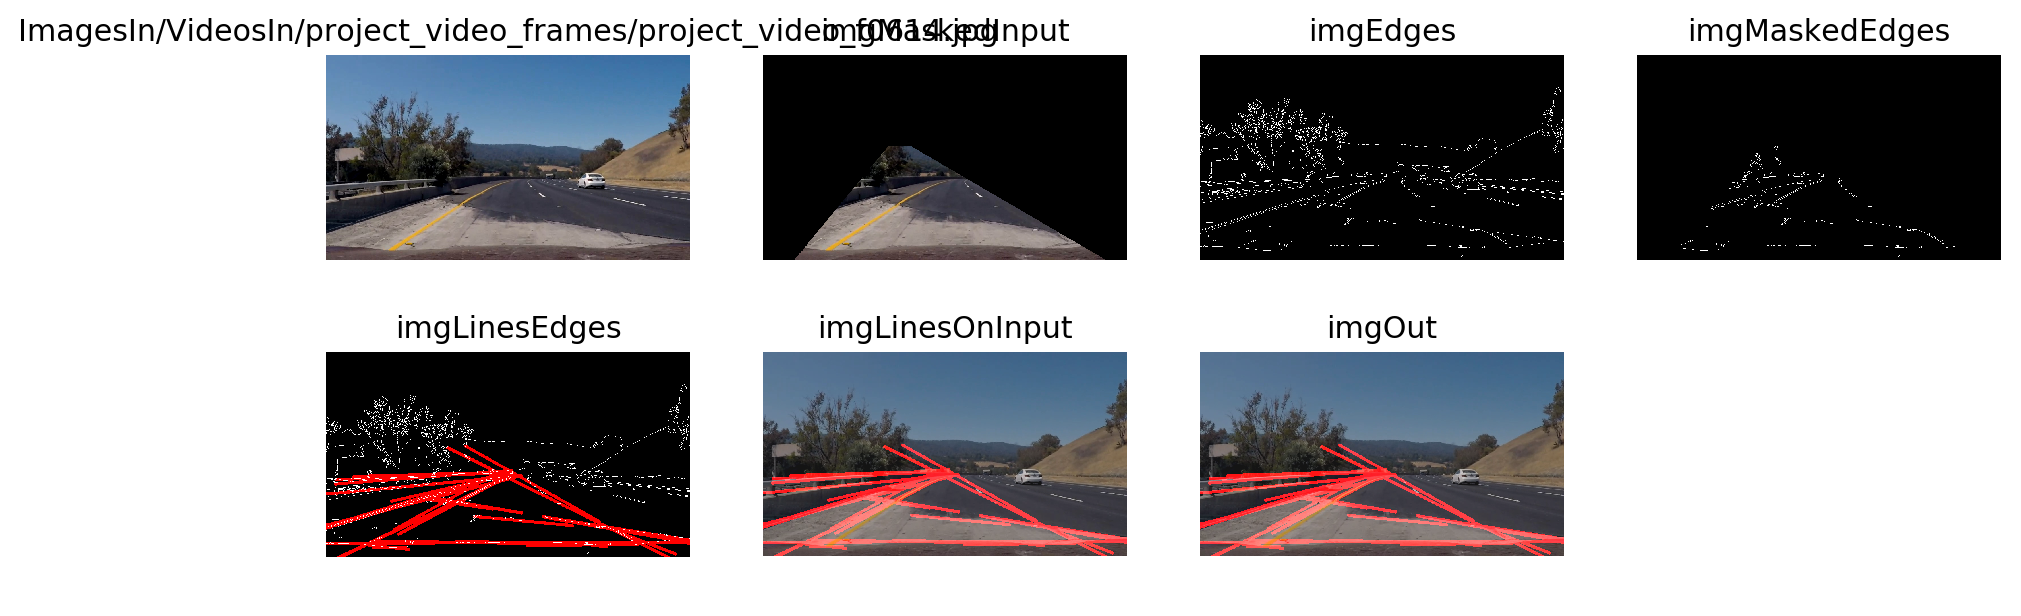

In [8]:
def ProcessSingleImage(imgInFileName):
    imgIn = mpimg.imread(imgInFileName)
    pipelineImgRecords, imgOut = ProcessImageLowlevel(imgIn, imgInFileName)
    PlotImageRecords(pipelineImgRecords)

imgInFileName = 'test_images/solidYellowLeft.jpg'
#imgInFileName = 'test_images/traingleQuiz.jpg'
#imgInFileName = 'test_images/whiteCarLaneSwitch.jpg'
#imgInFileName = 'test_images/solidYellowCurve2.jpg'
#imgInFileName = 'test_images/solidWhiteCurve.jpg'
imgInFileName = 'test_images/solidWhiteRight.jpg'
#imgInFileName = 'test_images/solidYellowCurve.jpg'
imgInFileName = "ImagesIn/VideosIn/project_video_frames/project_video_f0614.jpg"

ProcessSingleImage(imgInFileName)



In [9]:
from moviepy.editor import VideoFileClip
from IPython.display import HTML
import datetime

def ProcessVideo():
    fileNameBase = "solidWhiteRight"
    fileNameBase = "solidYellowLeft"
    #fileNameBase = "challenge"
    fileExt = ".mp4"
    folderInput = "test_videos/"
    folderOutput = "test_videos_output/"

    dt = datetime.datetime.now()
    strDT = "_{:%Y-%m-%dT%H:%M:%S}".format(dt)

    fileNameIn  = folderInput + fileNameBase + fileExt
    fileNameOut = folderOutput + fileNameBase + strDT + fileExt

    #clip1 = VideoFileClip(fileNameIn).subclip(0,3)
    clip1 = VideoFileClip(fileNameIn)
    white_clip = clip1.fl_image(ProcessImage) #NOTE: this function expects color images!!
    white_clip.write_videofile(fileNameOut, audio=False)
    
ProcessVideo()

numLines:  7
[MoviePy] >>>> Building video test_videos_output/solidYellowLeft_2018-08-15T19:27:27.mp4
[MoviePy] Writing video test_videos_output/solidYellowLeft_2018-08-15T19:27:27.mp4


  0%|          | 3/682 [00:00<00:25, 26.35it/s]

numLines:  7
numLines:  11
numLines:  9
numLines:  9
numLines:  9


  1%|          | 6/682 [00:00<00:26, 25.90it/s]

numLines:  7


  1%|▏         | 10/682 [00:00<00:23, 28.85it/s]

numLines:  7
numLines:  8
numLines:  8
numLines:  11
numLines:  7
numLines:  9


  2%|▏         | 13/682 [00:00<00:23, 28.69it/s]

numLines:  8


  2%|▏         | 17/682 [00:00<00:22, 29.67it/s]

numLines:  11
numLines:  11
numLines:  9
numLines:  10
numLines:  7
numLines:  7
numLines:  6


  4%|▎         | 24/682 [00:00<00:21, 30.20it/s]

numLines:  8
numLines:  6
numLines:  7
numLines:  8
numLines:  10
numLines:  8
numLines:  10


  4%|▍         | 27/682 [00:00<00:22, 29.55it/s]

numLines:  9
numLines:  10
numLines:  8


  4%|▍         | 30/682 [00:01<00:22, 29.28it/s]

numLines:  8


  5%|▍         | 34/682 [00:01<00:21, 29.67it/s]

numLines:  8
numLines:  9
numLines:  8
numLines:  10
numLines:  9
numLines:  9


  6%|▌         | 38/682 [00:01<00:21, 29.84it/s]

numLines:  10
numLines:  8
numLines:  10


  6%|▌         | 41/682 [00:01<00:21, 29.52it/s]

numLines:  8
numLines:  7
numLines:  7


  6%|▋         | 44/682 [00:01<00:22, 28.26it/s]

numLines:  7
numLines:  9
numLines:  7


  7%|▋         | 47/682 [00:01<00:22, 27.81it/s]

numLines:  9
numLines:  10
numLines:  8


  7%|▋         | 50/682 [00:01<00:23, 27.21it/s]

numLines:  8
numLines:  10
numLines:  10


  8%|▊         | 53/682 [00:02<00:25, 24.70it/s]

numLines:  8
numLines:  8


  8%|▊         | 56/682 [00:02<00:25, 24.33it/s]

numLines:  7
numLines:  8
numLines:  9
numLines:  7


  9%|▊         | 58/682 [00:02<00:26, 23.48it/s]

numLines:  6


  9%|▉         | 60/682 [00:02<00:27, 22.95it/s]

numLines:  9
numLines:  9
numLines:  9
numLines:  10


  9%|▉         | 63/682 [00:02<00:26, 23.01it/s]

numLines:  9


 10%|▉         | 66/682 [00:02<00:26, 22.96it/s]

numLines:  10
numLines:  9
numLines:  8
numLines:  6


 10%|█         | 69/682 [00:03<00:26, 22.97it/s]

numLines:  7
numLines:  8
numLines:  7
numLines:  7


 11%|█         | 75/682 [00:03<00:27, 22.16it/s]

numLines:  8
numLines:  9
numLines:  9
numLines:  9


 11%|█▏        | 77/682 [00:03<00:27, 22.03it/s]

numLines:  8


 12%|█▏        | 79/682 [00:03<00:28, 21.48it/s]

numLines:  8
numLines:  9
numLines:  8
numLines:  7


 12%|█▏        | 84/682 [00:03<00:27, 21.57it/s]

numLines:  7
numLines:  9
numLines:  7
numLines:  9


 13%|█▎        | 87/682 [00:04<00:27, 21.73it/s]

numLines:  9
numLines:  7
numLines:  8
numLines:  10
numLines:  8


 13%|█▎        | 90/682 [00:04<00:27, 21.61it/s]

numLines:  9


 14%|█▎        | 93/682 [00:04<00:27, 21.27it/s]

numLines:  9
numLines:  6
numLines:  6


 14%|█▍        | 95/682 [00:04<00:28, 20.94it/s]

numLines:  7
numLines:  7
numLines:  8
numLines:  7


 14%|█▍        | 98/682 [00:04<00:27, 21.11it/s]

numLines:  8
numLines:  7


 15%|█▍        | 101/682 [00:04<00:27, 21.19it/s]

numLines:  7
numLines:  8
numLines:  10


 15%|█▌        | 104/682 [00:04<00:27, 21.09it/s]

numLines:  11


 16%|█▌        | 107/682 [00:05<00:27, 21.14it/s]

numLines:  9
numLines:  11
numLines:  8
numLines:  8
numLines:  7


 16%|█▌        | 110/682 [00:05<00:27, 21.09it/s]

numLines:  8
numLines:  7
numLines:  9
numLines:  9


 17%|█▋        | 116/682 [00:05<00:26, 21.04it/s]

numLines:  10
numLines:  10
numLines:  9
numLines:  10
numLines:  9
numLines:  8


 18%|█▊        | 123/682 [00:05<00:26, 21.25it/s]

numLines:  8
numLines:  8
numLines:  8
numLines:  9
numLines:  9


 18%|█▊        | 126/682 [00:05<00:26, 21.18it/s]

numLines:  7
numLines:  8
numLines:  8


 19%|█▉        | 132/682 [00:06<00:26, 21.14it/s]

numLines:  11
numLines:  9
numLines:  8
numLines:  9
numLines:  6


 20%|█▉        | 135/682 [00:06<00:25, 21.15it/s]

numLines:  6
numLines:  7
numLines:  7
numLines:  10
numLines:  7
numLines:  7


 21%|██        | 141/682 [00:06<00:25, 21.24it/s]

numLines:  9
numLines:  9
numLines:  11
numLines:  10
numLines:  10


 22%|██▏       | 147/682 [00:06<00:25, 21.32it/s]

numLines:  7
numLines:  6
numLines:  6
numLines:  7
numLines:  7


 22%|██▏       | 150/682 [00:07<00:25, 21.24it/s]

numLines:  8
numLines:  7
numLines:  9
numLines:  9


 23%|██▎       | 156/682 [00:07<00:24, 21.22it/s]

numLines:  9
numLines:  8
numLines:  11
numLines:  8
numLines:  7


 24%|██▍       | 162/682 [00:07<00:24, 21.09it/s]

numLines:  8
numLines:  9
numLines:  9
numLines:  9
numLines:  10


 24%|██▍       | 165/682 [00:07<00:24, 21.11it/s]

numLines:  11
numLines:  9
numLines:  9
numLines:  9
numLines:  10


 25%|██▌       | 171/682 [00:08<00:24, 21.19it/s]

numLines:  8
numLines:  7
numLines:  8
numLines:  7
numLines:  10


 26%|██▌       | 174/682 [00:08<00:23, 21.17it/s]

numLines:  9
numLines:  8
numLines:  9
numLines:  9


 26%|██▋       | 180/682 [00:08<00:23, 21.11it/s]

numLines:  10
numLines:  9
numLines:  7
numLines:  9


 27%|██▋       | 183/682 [00:08<00:23, 21.18it/s]

numLines:  10
numLines:  6
numLines:  7
numLines:  8
numLines:  7


 28%|██▊       | 189/682 [00:08<00:23, 21.19it/s]

numLines:  10
numLines:  6
numLines:  8
numLines:  10
numLines:  10
numLines:  8


 29%|██▊       | 195/682 [00:09<00:23, 21.14it/s]

numLines:  7
numLines:  8
numLines:  7
numLines:  8


 29%|██▉       | 198/682 [00:09<00:22, 21.14it/s]

numLines:  7
numLines:  8
numLines:  8
numLines:  9
numLines:  9
numLines:  8


 30%|██▉       | 204/682 [00:09<00:22, 21.22it/s]

numLines:  8
numLines:  11
numLines:  9
numLines:  11
numLines:  10


 31%|███       | 210/682 [00:09<00:22, 21.28it/s]

numLines:  9
numLines:  8
numLines:  8
numLines:  7
numLines:  7


 32%|███▏      | 216/682 [00:10<00:21, 21.35it/s]

numLines:  8
numLines:  10
numLines:  8
numLines:  8
numLines:  10
numLines:  8


 33%|███▎      | 222/682 [00:10<00:21, 21.40it/s]

numLines:  9
numLines:  6
numLines:  7
numLines:  8
numLines:  9


 33%|███▎      | 225/682 [00:10<00:21, 21.45it/s]

numLines:  7
numLines:  9
numLines:  7
numLines:  7
numLines:  10


 34%|███▍      | 231/682 [00:10<00:20, 21.48it/s]

numLines:  8
numLines:  10
numLines:  8
numLines:  7
numLines:  6


 35%|███▍      | 237/682 [00:11<00:20, 21.51it/s]

numLines:  7
numLines:  8
numLines:  7
numLines:  7
numLines:  8


 35%|███▌      | 240/682 [00:11<00:20, 21.47it/s]

numLines:  8
numLines:  10
numLines:  10
numLines:  8
numLines:  7


 36%|███▌      | 246/682 [00:11<00:20, 21.57it/s]

numLines:  7
numLines:  6
numLines:  7
numLines:  8
numLines:  8
numLines:  8


 37%|███▋      | 252/682 [00:11<00:19, 21.61it/s]

numLines:  8
numLines:  9
numLines:  10
numLines:  10
numLines:  10


 37%|███▋      | 255/682 [00:11<00:19, 21.63it/s]

numLines:  11
numLines:  11
numLines:  9
numLines:  11
numLines:  7


 38%|███▊      | 261/682 [00:12<00:19, 21.62it/s]

numLines:  7
numLines:  8
numLines:  8
numLines:  7
numLines:  6
numLines:  8


 39%|███▉      | 267/682 [00:12<00:19, 21.60it/s]

numLines:  9
numLines:  9
numLines:  10
numLines:  9
numLines:  9


 40%|████      | 273/682 [00:12<00:18, 21.65it/s]

numLines:  8
numLines:  6
numLines:  7
numLines:  8
numLines:  8


 40%|████      | 276/682 [00:12<00:18, 21.70it/s]

numLines:  7
numLines:  9
numLines:  10
numLines:  7
numLines:  8


 42%|████▏     | 285/682 [00:13<00:18, 21.74it/s]

numLines:  8
numLines:  9
numLines:  8
numLines:  7
numLines:  9
numLines:  11


 42%|████▏     | 288/682 [00:13<00:18, 21.72it/s]

numLines:  9
numLines:  13
numLines:  12
numLines:  11
numLines:  11


 43%|████▎     | 294/682 [00:13<00:17, 21.69it/s]

numLines:  14
numLines:  11
numLines:  9
numLines:  8
numLines:  6


 44%|████▍     | 301/682 [00:13<00:17, 21.80it/s]

numLines:  6
numLines:  9
numLines:  8
numLines:  10
numLines:  8
numLines:  9


 45%|████▍     | 304/682 [00:13<00:17, 21.77it/s]

numLines:  11
numLines:  10
numLines:  11
numLines:  8
numLines:  9


 45%|████▌     | 310/682 [00:14<00:17, 21.85it/s]

numLines:  8
numLines:  7
numLines:  6
numLines:  7
numLines:  10


 46%|████▋     | 316/682 [00:14<00:16, 21.83it/s]

numLines:  9
numLines:  9
numLines:  9
numLines:  10
numLines:  10


 47%|████▋     | 319/682 [00:14<00:16, 21.85it/s]

numLines:  9
numLines:  10
numLines:  8
numLines:  9
numLines:  9


 48%|████▊     | 325/682 [00:14<00:16, 21.88it/s]

numLines:  8
numLines:  8
numLines:  10
numLines:  7
numLines:  10
numLines:  9


 49%|████▊     | 331/682 [00:15<00:16, 21.81it/s]

numLines:  8
numLines:  9
numLines:  8
numLines:  7
numLines:  8


 49%|████▉     | 334/682 [00:15<00:15, 21.84it/s]

numLines:  8
numLines:  8
numLines:  8
numLines:  8
numLines:  7


 50%|████▉     | 340/682 [00:15<00:15, 21.85it/s]

numLines:  9
numLines:  8
numLines:  8
numLines:  8
numLines:  7
numLines:  6


 51%|█████     | 346/682 [00:15<00:15, 21.87it/s]

numLines:  5
numLines:  6
numLines:  7
numLines:  9
numLines:  7
numLines:  8


 52%|█████▏    | 355/682 [00:16<00:14, 21.96it/s]

numLines:  9
numLines:  9
numLines:  8
numLines:  10
numLines:  9
numLines:  7


 52%|█████▏    | 358/682 [00:16<00:14, 21.98it/s]

numLines:  7
numLines:  6
numLines:  7
numLines:  8
numLines:  9
numLines:  8


 54%|█████▍    | 367/682 [00:16<00:14, 22.05it/s]

numLines:  11
numLines:  10
numLines:  10
numLines:  11
numLines:  10
numLines:  9


 54%|█████▍    | 370/682 [00:16<00:14, 22.09it/s]

numLines:  8
numLines:  8
numLines:  9
numLines:  10
numLines:  9


 55%|█████▌    | 376/682 [00:17<00:13, 22.09it/s]

numLines:  9
numLines:  10
numLines:  9
numLines:  8
numLines:  9
numLines:  9


 56%|█████▌    | 382/682 [00:17<00:13, 22.08it/s]

numLines:  8
numLines:  7
numLines:  8
numLines:  7


 56%|█████▋    | 385/682 [00:17<00:13, 22.11it/s]

numLines:  9
numLines:  9
numLines:  9
numLines:  10
numLines:  9


 57%|█████▋    | 391/682 [00:17<00:13, 22.13it/s]

numLines:  11
numLines:  11
numLines:  10
numLines:  9
numLines:  8


 58%|█████▊    | 397/682 [00:17<00:12, 22.17it/s]

numLines:  8
numLines:  9
numLines:  8
numLines:  8
numLines:  7


 59%|█████▊    | 400/682 [00:18<00:12, 22.17it/s]

numLines:  6
numLines:  9
numLines:  9
numLines:  9


 60%|█████▉    | 406/682 [00:18<00:12, 22.12it/s]

numLines:  9
numLines:  8
numLines:  8
numLines:  7
numLines:  8


 60%|██████    | 412/682 [00:18<00:12, 22.16it/s]

numLines:  8
numLines:  7
numLines:  10
numLines:  12
numLines:  9
numLines:  11


 61%|██████    | 415/682 [00:18<00:12, 22.16it/s]

numLines:  10
numLines:  10
numLines:  8
numLines:  8
numLines:  6


 62%|██████▏   | 421/682 [00:19<00:11, 22.15it/s]

numLines:  7
numLines:  7
numLines:  8
numLines:  9
numLines:  10


 63%|██████▎   | 427/682 [00:19<00:11, 22.18it/s]

numLines:  8
numLines:  9
numLines:  12
numLines:  10
numLines:  10
numLines:  9


 63%|██████▎   | 430/682 [00:19<00:11, 22.19it/s]

numLines:  7
numLines:  8
numLines:  8
numLines:  9
numLines:  8


 64%|██████▍   | 436/682 [00:19<00:11, 22.17it/s]

numLines:  8
numLines:  10
numLines:  10
numLines:  10
numLines:  10
numLines:  11


 65%|██████▍   | 442/682 [00:19<00:10, 22.23it/s]

numLines:  9
numLines:  9
numLines:  7
numLines:  7
numLines:  6
numLines:  9


 66%|██████▌   | 451/682 [00:20<00:10, 22.27it/s]

numLines:  8
numLines:  9
numLines:  8
numLines:  9
numLines:  9
numLines:  10


 67%|██████▋   | 454/682 [00:20<00:10, 22.24it/s]

numLines:  10
numLines:  7
numLines:  8
numLines:  9
numLines:  7


 68%|██████▊   | 461/682 [00:20<00:09, 22.29it/s]

numLines:  7
numLines:  8
numLines:  9
numLines:  10
numLines:  10


 68%|██████▊   | 464/682 [00:20<00:09, 22.30it/s]

numLines:  10
numLines:  11
numLines:  8
numLines:  9
numLines:  8


 69%|██████▉   | 470/682 [00:21<00:09, 22.26it/s]

numLines:  7
numLines:  8
numLines:  5
numLines:  7


 69%|██████▉   | 473/682 [00:21<00:09, 22.24it/s]

numLines:  8
numLines:  7
numLines:  9
numLines:  9


 70%|███████   | 479/682 [00:21<00:09, 22.27it/s]

numLines:  10
numLines:  11
numLines:  8
numLines:  6
numLines:  6
numLines:  6
numLines:  8


 71%|███████   | 483/682 [00:21<00:08, 22.31it/s]

numLines:  8
numLines:  8
numLines:  7
numLines:  11
numLines:  11


 72%|███████▏  | 489/682 [00:21<00:08, 22.30it/s]

numLines:  12
numLines:  9
numLines:  11
numLines:  9
numLines:  7


 73%|███████▎  | 495/682 [00:22<00:08, 22.29it/s]

numLines:  7
numLines:  8
numLines:  7
numLines:  9
numLines:  8
numLines:  8


 73%|███████▎  | 501/682 [00:22<00:08, 22.33it/s]

numLines:  9
numLines:  9
numLines:  8
numLines:  9
numLines:  8


 74%|███████▍  | 507/682 [00:22<00:07, 22.36it/s]

numLines:  8
numLines:  8
numLines:  6
numLines:  7
numLines:  8
numLines:  7


 75%|███████▌  | 513/682 [00:22<00:07, 22.35it/s]

numLines:  8
numLines:  8
numLines:  8
numLines:  9
numLines:  10


 76%|███████▌  | 516/682 [00:23<00:07, 22.34it/s]

numLines:  7
numLines:  8
numLines:  8
numLines:  9
numLines:  8


 77%|███████▋  | 523/682 [00:23<00:07, 22.39it/s]

numLines:  9
numLines:  10
numLines:  9
numLines:  10
numLines:  11
numLines:  9


 78%|███████▊  | 529/682 [00:23<00:06, 22.39it/s]

numLines:  10
numLines:  8
numLines:  9
numLines:  7
numLines:  7


 78%|███████▊  | 535/682 [00:23<00:06, 22.43it/s]

numLines:  8
numLines:  10
numLines:  10
numLines:  9
numLines:  7
numLines:  9


 79%|███████▉  | 538/682 [00:24<00:06, 22.39it/s]

numLines:  10
numLines:  12
numLines:  11
numLines:  9


 79%|███████▉  | 541/682 [00:24<00:06, 22.39it/s]

numLines:  9
numLines:  9
numLines:  8
numLines:  7


 80%|████████  | 547/682 [00:24<00:06, 22.38it/s]

numLines:  9
numLines:  8
numLines:  7
numLines:  8
numLines:  9


 81%|████████  | 554/682 [00:24<00:05, 22.45it/s]

numLines:  11
numLines:  10
numLines:  8
numLines:  8
numLines:  7
numLines:  6


 82%|████████▏ | 557/682 [00:24<00:05, 22.46it/s]

numLines:  9
numLines:  7
numLines:  8
numLines:  8
numLines:  7
numLines:  8


 83%|████████▎ | 564/682 [00:25<00:05, 22.48it/s]

numLines:  10
numLines:  8
numLines:  12
numLines:  10
numLines:  9


 84%|████████▎ | 570/682 [00:25<00:04, 22.48it/s]

numLines:  8
numLines:  9
numLines:  9
numLines:  8
numLines:  11


 84%|████████▍ | 573/682 [00:25<00:04, 22.49it/s]

numLines:  8
numLines:  9
numLines:  12
numLines:  10
numLines:  8


 85%|████████▍ | 579/682 [00:25<00:04, 22.49it/s]

numLines:  9
numLines:  7
numLines:  7
numLines:  8
numLines:  11
numLines:  9


 86%|████████▌ | 585/682 [00:26<00:04, 22.48it/s]

numLines:  9
numLines:  9
numLines:  7
numLines:  8


 87%|████████▋ | 591/682 [00:26<00:04, 22.51it/s]

numLines:  7
numLines:  10
numLines:  9
numLines:  8
numLines:  8
numLines:  9


 87%|████████▋ | 594/682 [00:26<00:03, 22.52it/s]

numLines:  7
numLines:  6
numLines:  10
numLines:  7
numLines:  8


 88%|████████▊ | 601/682 [00:26<00:03, 22.54it/s]

numLines:  10
numLines:  9
numLines:  8
numLines:  11
numLines:  11
numLines:  7
numLines:  10


 89%|████████▉ | 607/682 [00:26<00:03, 22.51it/s]

numLines:  7
numLines:  9
numLines:  7
numLines:  7


 89%|████████▉ | 610/682 [00:27<00:03, 22.49it/s]

numLines:  8
numLines:  8
numLines:  9
numLines:  9
numLines:  7


 90%|█████████ | 616/682 [00:27<00:02, 22.53it/s]

numLines:  8
numLines:  9
numLines:  7
numLines:  8
numLines:  8


 91%|█████████ | 622/682 [00:27<00:02, 22.54it/s]

numLines:  9
numLines:  9
numLines:  7
numLines:  10
numLines:  9


 92%|█████████▏| 625/682 [00:27<00:02, 22.53it/s]

numLines:  9
numLines:  8
numLines:  9
numLines:  8
numLines:  7
numLines:  8


 93%|█████████▎| 631/682 [00:28<00:02, 22.53it/s]

numLines:  9
numLines:  8
numLines:  8
numLines:  7
numLines:  7
numLines:  8


 94%|█████████▎| 638/682 [00:28<00:01, 22.55it/s]

numLines:  10
numLines:  10
numLines:  9
numLines:  7


 94%|█████████▍| 641/682 [00:28<00:01, 22.56it/s]

numLines:  8
numLines:  8
numLines:  7
numLines:  9
numLines:  9
numLines:  7


 95%|█████████▍| 647/682 [00:28<00:01, 22.56it/s]

numLines:  8
numLines:  8
numLines:  10
numLines:  9
numLines:  10


 96%|█████████▌| 653/682 [00:28<00:01, 22.55it/s]

numLines:  9
numLines:  7
numLines:  7
numLines:  8
numLines:  7


 96%|█████████▌| 656/682 [00:29<00:01, 22.58it/s]

numLines:  9
numLines:  9
numLines:  8
numLines:  7
numLines:  10


 97%|█████████▋| 662/682 [00:29<00:00, 22.58it/s]

numLines:  10
numLines:  9
numLines:  12
numLines:  8
numLines:  9
numLines:  6
numLines:  6


 98%|█████████▊| 669/682 [00:29<00:00, 22.57it/s]

numLines:  8
numLines:  7
numLines:  7
numLines:  9
numLines:  9


 99%|█████████▉| 676/682 [00:29<00:00, 22.61it/s]

numLines:  10
numLines:  9
numLines:  9
numLines:  8
numLines:  11
numLines:  8
numLines:  8


100%|█████████▉| 681/682 [00:30<00:00, 22.61it/s]

numLines:  7
numLines:  7
numLines:  8


[MoviePy] Done.
[MoviePy] >>>> Video ready: test_videos_output/solidYellowLeft_2018-08-15T19:27:27.mp4 

